# Wyżarzanie równoległe


W tym algorytmie używamy następującej konwencji modelu Isinga, gdzie macież $\bm{J}$ jest symetryczna. Dla przypomnienia, wróz na Hamiltonian wygląda następująco:

$$
H_{Ising} = -\sum_{i<j} J_{ij} \sigma_i \sigma_j - \sum_{i} h_i \sigma_{j} = -\frac{1}{2} \bm{\sigma}^T \bm{J} \bm{\sigma} - \bm{h}^T \bm{\sigma}
$$

Inspirując się wyżarzaniem kwantowym, 

$$
H_{system} = \lambda (t) H_{initial} + H_{Ising} 
$$

$$
H_{initial} = \frac{1}{2} \sum_i x_i^2
$$

$$
\text{gradient} = \nabla H_{system} = \nabla H_{Ising} + \lambda (t) \nabla H_{initial} = - \bm{J} \bm{\sigma} - \bm{h} + \lambda (t) \bm{x}
$$


Podczas rozwiązywania, po każdej iteracji analogowy pseudo-spin $x$ jest obcinany do wartości pomiędzy $-1$ i $1$. Formalnie:

$$
\text{clip}(x, -1, 1) = \max(-1, \min(1, x))
$$

Pozwala to zapopiec sytuacji że parametr zacznie rosnąć w nieskończoność i nie ma wpływu na efekt binaryzacji.

$$
m(t + 1) = \beta * m(t) - \alpha * gradient
$$

$$
x(t + 1) = x(t) + m(t + 1)
$$

## Pseudokod

Niech $T$ będzie ustaloną ilością kroków algorytmu

1. Zinicjalizuj losowy stan początowy $s(0)$, $\bm{x}(0) = 0$, $\bm{m}(0) = 0$
2. For t $\in [1, \ldots, T]$  
    1. gradient = $- \bm{J} \bm{\sigma} - \bm{h} + \lambda (t) \bm{x}$
    2. $m(t + 1) = \beta * m(t) - \alpha * gradient$
    3. $\text{clip}(m(t + 1), -1, 1)$
    4. $x(t + 1) = x(t) + m(t + 1)$
    5. $\text{clip}(x(t + 1), -1, 1)$
    6. $s(t+1) = \text{sign}(x)$
3. Zwróć $s(T)$ 

WIP


![image](pictures/pa_placeholder.png)

In [1]:
# Implementacja Algorytmu dla jednej trajektorii


import numpy as np
from typing import Optional
from funkcje_pomocnicze import calculate_energy


def calculate_gradient(J: np.ndarray, h: np.ndarray, x: np.ndarray, state: np.ndarray, lambda_t: float) -> np.ndarray:
    return -1 * state @ J - h + lambda_t * x


def parrarel_annealing(J, h, step_size: float, lambda_t_max: float, num_steps: int, 
                       schedule: Optional[np.ndarray] = None, schedule_endpoint: Optional[float] = 0):
    n = len(h)
    x = np.zeros(n)  # stan podstawowy dla H_innit = sum(x**2)
    momentum = np.zeros(n)
    state = np.random.choice([-1, 1], size=n) # losowy stan początkowy

    if schedule is None:
        schedule = np.linspace(lambda_t_max, schedule_endpoint, num=num_steps)

    for k in range(num_steps):
        lambda_t = schedule[k]
        gradient = calculate_gradient(J, h, x, state, lambda_t)
        momentum = (1 - step_size) * momentum - step_size * gradient
        momentum = np.clip(momentum, -1, 1)
        x += momentum
        x = np.clip(x, -1, 1)
        state = np.sign(x)

    return state, calculate_energy(J, h, state)



    


In [3]:

# Testujemy algorytm na instancji z 216 spinów i z geometryczną strukturą podobną do pegasus QPU

import os
import numpy as np

from funkcje_pomocnicze import read_instance, test_pegasus


J, h = read_instance(test_pegasus.path, convention="minus_half")


state, energy = parrarel_annealing(J, h, step_size=0.01, lambda_t_max=10, num_steps=1000)


print(f"Otrzymana energia: {energy}")
print(f"Stan podstawowy: {test_pegasus.best_energy}")



Otrzymana energia: -467.0

Stan podstawowy: -469.0


## Zrównoleglenie

Przez to że algorytm sam w sobie jest stochastyczny nie mamy gwarancji że w trakcie jednego wywołania otrzymamy najlepszy możliwy wynik. Jedym z rozwiązać tego problemu jest zrównoleglenie algorytmu. Oznacza to, że jednocześnie śledzimy wiele "trajektorii" i na końcu obliczeń możemy wybrać najlepszą z nich. Można tego dokonać wywołując algorytm wielokrotnie, ale jest to nieefektywne. Lepszym rozwiązaniem jest trzymanie wielu stanów ułożonych w macierz. Niech $\sigma_i$ będzie stanem, wtedy mając $M$ trajektorii:

$$
\sigma = \begin{bmatrix}
\vert & \vert & \cdots & \vert \\
\sigma_1 & \sigma_2 & \cdots & \sigma_M \\
\vert & \vert & \cdots & \vert
\end{bmatrix}
$$

Wybór czy trzymamy stany w kolumnach czy w wierszach jest arbitralny. To podejście pozwala nam równolegle liczyć wiele rozwiązań i jest pełną formą tego algorytmu.

W podobny sposób trzymamy $x$ i momentum. Będzie to wymagało pewnych technicznych zmian w kodzie, ale główna idea pozostaje niezmieniona.

In [2]:
# Implementacja wyżarzanie równoległego z wieloma trajektoriami

import numpy as np
from funkcje_pomocnicze import calculate_energy_matrix
from typing import Optional
from tqdm import tqdm


def calculate_gradient_matrix(J: np.ndarray, h: np.ndarray, x: np.ndarray, state: np.ndarray, lambda_t: float) -> np.ndarray:
    n = len(h)
    # używamy brodcastingu który jest wykonywany automatycznie w bibliotece numpy
    return -1 * J @ state - h.reshape((n, 1)) + lambda_t * x


def parrarel_annealing_multiple_trajectores(J, h, step_size: float, lambda_t_max: float, num_steps: int, num_trajectories: int,
                       schedule: Optional[np.ndarray] = None, schedule_endpoint: Optional[float] = 0):
    n = len(h)
    x = np.zeros((n, num_trajectories))  # stan podstawowy dla H_innit = sum(x**2)
    momentum = np.zeros((n, num_trajectories))
    state = np.random.choice([-1, 1], size=(n, num_trajectories))  # losowy stan początkowy

    if schedule is None:
        schedule = np.linspace(lambda_t_max, schedule_endpoint, num=num_steps)

    for k in tqdm(range(num_steps), desc="wyżarzanie równoległe"):
        lambda_t = schedule[k]
        gradient = calculate_gradient_matrix(J, h, x, state, lambda_t)
        momentum = (1 - step_size) * momentum - step_size * gradient
        momentum = np.clip(momentum, -1, 1)
        x += momentum
        x = np.clip(x, -1, 1)
        state = np.sign(x)

    return state, calculate_energy_matrix(J, h, state)




wyżarzanie równoległe: 100%|██████████| 1000/1000 [00:00<00:00, 6789.83it/s]


Otrzymana energia: -469.0
Stan podstawowy: -469.0


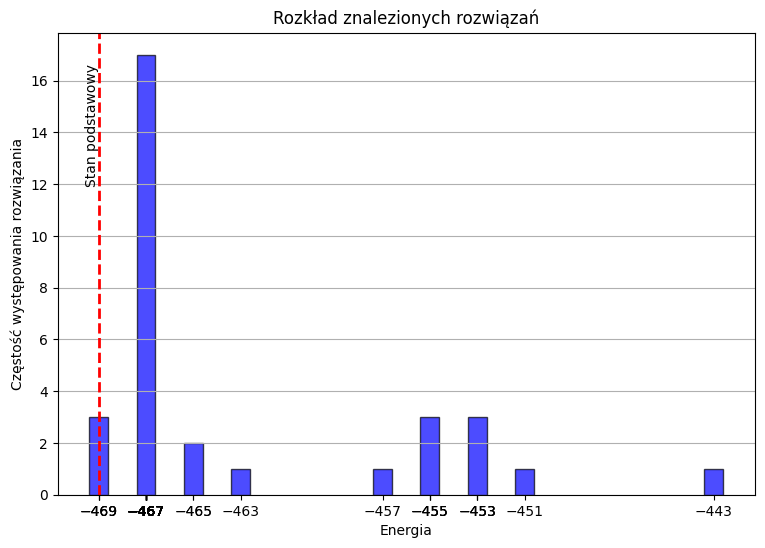

In [ ]:
# Ten sam test, wykorzystując wiele trajektorii

import matplotlib.pyplot as plt
import numpy as np
from funkcje_pomocnicze import read_instance, test_pegasus


J, h = read_instance(test_pegasus.path, convention="minus_half")

states, energies = parrarel_annealing_multiple_trajectores(J, h, step_size=0.01, lambda_t_max=10, num_steps=1000, num_trajectories=32)



print(f"Otrzymana energia: {min(energies)}")
print(f"Stan podstawowy: {test_pegasus.best_energy}")

unique_values, counts = np.unique(energies, return_counts=True)


plt.figure(figsize=(9, 6))
plt.bar(unique_values, counts, color='blue', edgecolor='black', alpha=0.7)
plt.xticks(energies)
plt.axvline(x=test_pegasus.best_energy, color='red', linestyle='--', linewidth=2)
plt.text(test_pegasus.best_energy, plt.ylim()[1]*0.8, 'Stan podstawowy', color='black', rotation=90,
         verticalalignment='center', horizontalalignment='right')

plt.xlabel("Energia")
plt.ylabel("Częstość występowania rozwiązania")
plt.title("Rozkład ilości znalezionych rozwiązań")
plt.grid(axis="y")
plt.show()

Z tego wykresu widać, że dla testowanej instancji ten algorytm ma mocną tendencje by utykać w optimum lokalnym, które w tym wypadku jest pierwszym stanem wzbudzonym. 

## Zachowanie algorytmu dla różnych wartości parametrów.



zbieranie danych: 100%|██████████| 28/28 [01:25<00:00,  3.07s/it]


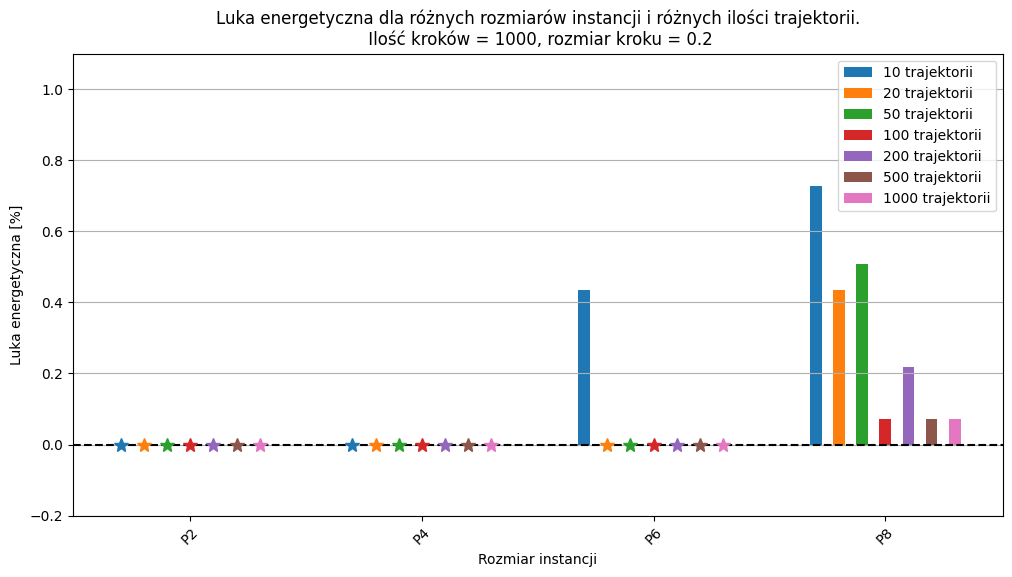

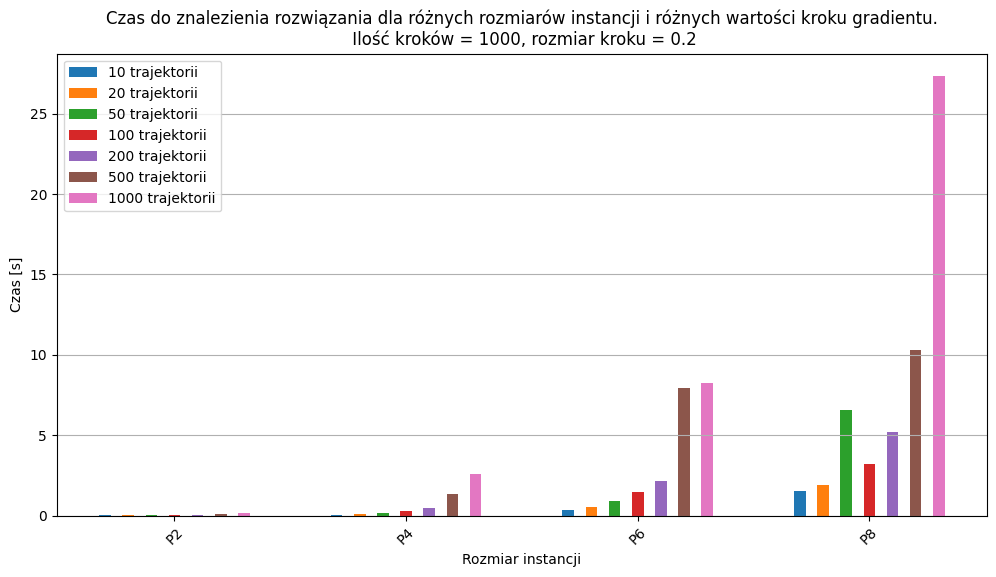

In [28]:
# zachowanie względem ilości trajektorii
import time
import matplotlib.pyplot as plt
import numpy as np
from funkcje_pomocnicze import read_instance, P2, P4, P6, P8
from tqdm import tqdm
from IPython.utils.io import capture_output

trajs = [10, 20, 50, 100, 200, 500, 1000]
gaps = {}
times = {}
with tqdm(total=4*len(trajs), desc="zbieranie danych") as pbar:
    for instance in [P2, P4, P6, P8]:
        for num_traj in trajs:
            J, h = read_instance(instance.path, convention="minus_half")
            with capture_output() as captured:
                start = time.time()
                states, energies = parrarel_annealing_multiple_trajectores(J, h, step_size=0.2, lambda_t_max=10, num_steps=1000, 
                                                                           num_trajectories=num_traj)
                end = time.time()
            energy = min(energies)
            gap = (instance.best_energy - energy)/instance.best_energy
            gaps[(instance.name, num_traj)] = gap * 100
            times[(instance.name, num_traj)] = end - start
            pbar.update(1)


instancje = ["P2", "P4", "P6", "P8"]

x = np.arange(len(instancje))
width = 0.05
offset = 0.1

fig, ax = plt.subplots(figsize=(12, 6))
barset = []
param = [-3, -2, -1, 0, 1, 2, 3]
for idx, s in enumerate(trajs):
    a = [gaps[(i, s)] for i in instancje]
    bar = ax.bar(x + offset * param[idx], a, width, label=rf"{s} trajektorii")
    barset.append(bar)


(y_min, y_max) = ax.get_ylim()
if y_max < 1.1:
    y_max = 1.1
ax.set_ylim((-0.2, y_max))
ax.set_xlabel("Rozmiar instancji")
ax.set_xticks(x)
ax.set_xticklabels(instancje, rotation=45)
ax.set_ylabel("Luka energetyczna [%]")
ax.set_title("Luka energetyczna dla różnych rozmiarów instancji i różnych ilości trajektorii.\n Ilość kroków = 1000, rozmiar kroku = 0.2")
ax.axhline(0, color='black', linestyle='--')

ax.legend()

for bars in barset:
    for bar in bars:
        if bar.get_height() == 0:
            center = bar.get_x() + bar.get_width()/2
            ax.plot(center, 0, marker='*', markersize=10, color=bar.get_facecolor())
plt.grid(axis="y")
plt.show()

fig2, ax2 = plt.subplots(figsize=(12, 6))
for idx, s in enumerate(trajs):
    a = [times[(i, s)] for i in instancje]
    bar = ax2.bar(x + offset * param[idx], a, width, label=rf"{s} trajektorii")

ax2.set_xlabel("Rozmiar instancji")
ax2.set_xticks(x)
ax2.set_xticklabels(instancje, rotation=45)
ax2.set_ylabel("Czas [s]")
ax2.set_title("Czas do znalezienia rozwiązania dla różnych rozmiarów instancji i różnych wartości kroku gradientu.\n Ilość kroków = 1000, rozmiar kroku = 0.2")
ax2.legend()

plt.grid(axis="y")
plt.show()

zbieranie danych:   0%|          | 0/28 [00:00<?, ?it/s]

zbieranie danych: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]


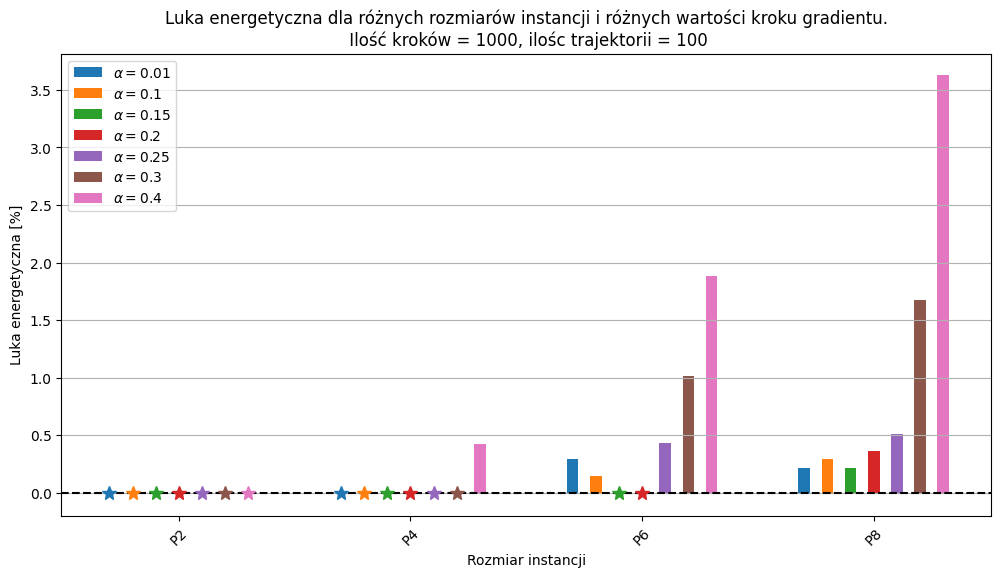

In [29]:
# zachowanie względem rozmiaru kroku w gradiencie

import time
import matplotlib.pyplot as plt
import numpy as np
from funkcje_pomocnicze import read_instance, P2, P4, P6, P8
from tqdm import tqdm
from IPython.utils.io import capture_output

stepsizes = [0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4]
gaps = {}
times = {}
with tqdm(total=4*len(stepsizes), desc="zbieranie danych") as pbar:
    for instance in [P2, P4, P6, P8]:
        for step_size in stepsizes:
            J, h = read_instance(instance.path, convention="minus_half")
            with capture_output() as captured:
                start = time.time()
                states, energies = parrarel_annealing_multiple_trajectores(J, h, step_size=step_size, lambda_t_max=10, num_steps=1000, 
                                                                           num_trajectories=100)
                end = time.time()
            energy = min(energies)
            gap = (instance.best_energy - energy)/instance.best_energy
            if gap < 0:
                print(instance.name, energy)
            gaps[(instance.name, step_size)] = gap * 100
            times[(instance.name, step_size)] = end - start
            pbar.update(1)


instancje = ["P2", "P4", "P6", "P8"]

x = np.arange(len(instancje))
width = 0.05
offset = 0.1

fig, ax = plt.subplots(figsize=(12, 6))
barset = []
param = [-3, -2, -1, 0, 1, 2, 3]
for idx, s in enumerate(stepsizes):
    a = [gaps[(i, s)] for i in instancje]
    bar = ax.bar(x + offset * param[idx], a, width, label=rf"$\alpha={s}$")
    barset.append(bar)


(y_min, y_max) = ax.get_ylim()
ax.set_ylim((-0.2, y_max))
ax.set_xlabel("Rozmiar instancji")
ax.set_xticks(x)
ax.set_xticklabels(instancje, rotation=45)
ax.set_ylabel("Luka energetyczna [%]")
ax.set_title("Luka energetyczna dla różnych rozmiarów instancji i różnych wartości kroku gradientu.\n Ilość kroków = 1000, ilośc trajektorii = 100")
ax.axhline(0, color='black', linestyle='--')

ax.legend()

for bars in barset:
    for bar in bars:
        if bar.get_height() == 0:
            center = bar.get_x() + bar.get_width()/2
            ax.plot(center, 0, marker='*', markersize=10, color=bar.get_facecolor())
plt.grid(axis="y")
plt.show()
    

# fig2, ax2 = plt.subplots(figsize=(12, 6))
# for idx, s in enumerate(stepsizes):
#     a = [times[(i, s)] for i in instancje]
#     bar = ax2.bar(x + offset * param[idx], a, width, label=rf"$\alpha={s}$")

# ax2.set_xlabel("Rozmiar instancji")
# ax2.set_xticks(x)
# ax2.set_xticklabels(instancje, rotation=45)
# ax2.set_ylabel("Czas [s]")
# ax2.set_title("Czas do znalezienia rozwiązania dla różnych rozmiarów instancji i różnych wartości kroku gradientu.\n Ilość kroków = 1000, ilośc trajektorii = 100")
# ax2.legend()

# plt.grid(axis="y")
# plt.show()


# Bibliografia

* Jiang, M., Shan, K., He, C. *et al.* Efficient combinatorial optimization by quantum-inspired parallel annealing in analogue memristor crossbar. *Nat Commun* **14**, 5927 (2023). DOI: [10.1038/s41467-023-41647-2](https://doi.org/10.1038/s41467-023-41647-2)